### Charger les valeurs d'accuracy construites dans un précédent script (2018-02-16_clasiffier)

In [1]:
import numpy as np
import os

path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    print('Loading accuracy...')
    accuracy =  np.load(path)
    print(accuracy)

Loading accuracy...
[[0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 ...
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]
 [0.0974 0.0974 0.0974 ... 0.0974 0.0974 0.0974]]


### Afficher un couple carte de certitude/image

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from LogGabor import LogGabor

def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 8, 5, 2, 128, 128
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

def accuracy_128(i_offset, j_offset):
    N_pic = 128
    center = (128-55)//2
    
    #accuracy_128 = accuracy[0][0] * np.ones((N_pic,N_pic))
    accuracy_128 = 0.1 * np.ones((N_pic,N_pic))
    accuracy_128[(center+i_offset):(center+55+i_offset),(center+j_offset):(center+55+j_offset)] = accuracy
    
    accuracy_LP = phi_vector @ np.ravel(accuracy_128)
    
    return accuracy_LP

def mnist_128(data, i_offset, j_offset):
    N_pic = 128
    center = (128-28)//2
    
    data_128 = data.min() * np.ones((128,128))
    data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

    data_LP = phi_vector @ np.ravel(data_128)
     
    return data_LP

def couples(data, i_offset, j_offset):
    v = mnist_128(data, i_offset, j_offset)
    a = accuracy_128(i_offset, j_offset)
    
    return (v,a)

def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return value

In [9]:
energy.sum(axis=-1).shape

(8, 5)

the sum is one?  [  86.1377377   106.6880124   343.24230194 1315.04114655 5212.63705234
   90.46229351  106.6880124   342.50506868 1315.04114655 5208.41316211
   86.1377377   106.6880124   343.24230194 1315.04114655 5212.63705234
   90.46229351  106.6880124   342.50506868 1315.04114655 5208.41316211
   86.1377377   106.6880124   343.24230194 1315.04114655 5212.63705234
   90.46229351  106.6880124   342.50506868 1315.04114655 5208.41316211
   86.1377377   106.6880124   343.24230194 1315.04114655 5212.63705234
   90.46229351  106.6880124   342.50506868 1315.04114655 5208.41316211]
(6, 8, 5, 2, 16384) (8, 5, 16384)


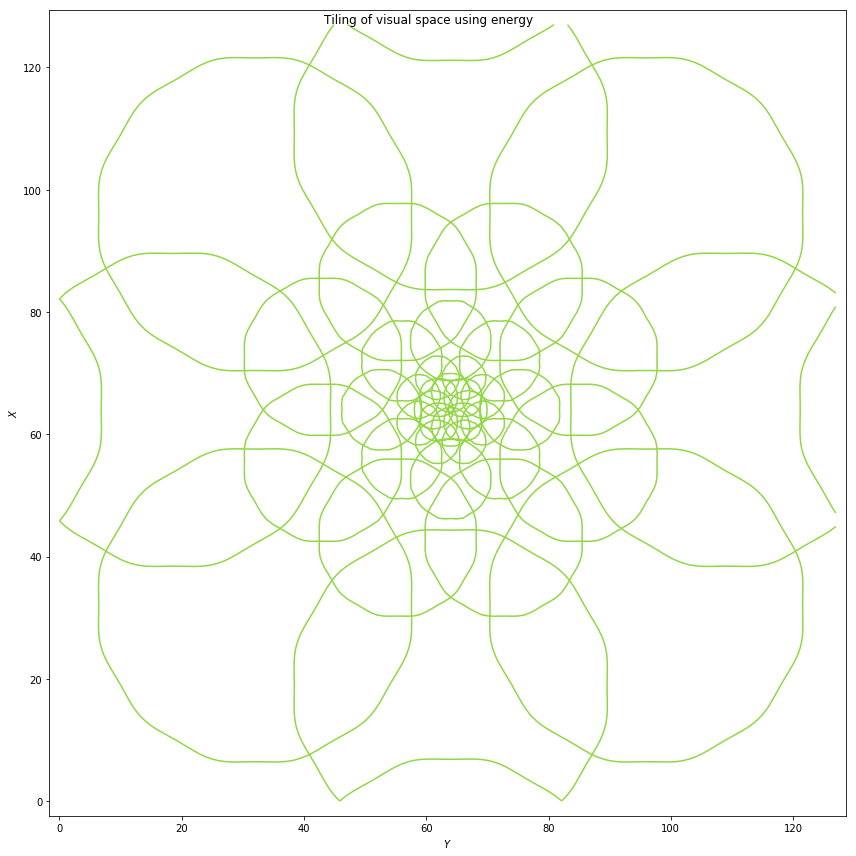

In [12]:
FIG_WIDTH = 12
FIGSIZE=(FIG_WIDTH, .618 * FIG_WIDTH)

energy = (phi**2).sum(axis=(0,3)) / energy.sum(axis=-1)[:, :, None]

print ('the sum is one? ', energy.sum(axis=-1).ravel())
print(phi.shape, energy.shape)
fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_orient):
    for i_scale in range(N_scale):
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()
#plt.savefig('logPolar_shape.pdf')

In [12]:
i_offset, j_offset = np.random.randn()*10, np.random.randn()*10 
couples(i_offset, j_offset)

(array([ -2.37780689e-03,   3.05003533e-03,  -9.24149246e-03,
         -1.72936450e-02,  -1.68931814e-01,  -1.62894933e-01,
          2.01524522e-01,  -1.13139074e+00,  -4.53293760e-01,
         -2.14000185e+00,  -2.26621179e-04,  -7.71483353e-04,
          1.53634136e-02,   8.14292051e-03,   1.40983082e-01,
         -1.11213371e-01,  -8.87080938e-02,   1.64309769e+00,
          2.92538732e+00,   2.70689820e+00,   1.66037391e-03,
          8.94968788e-04,  -3.05162786e-02,  -2.05435185e-02,
         -2.01986317e-01,   7.09279916e-02,   1.76053052e+00,
         -2.20183459e+00,  -1.03147402e+00,  -1.08170237e+01,
         -4.22747468e-03,   3.33215311e-03,   1.80120171e-01,
          1.67508344e-02,   2.22481804e-01,   2.19025454e-02,
         -2.24189139e+00,   8.08811169e+00,  -1.20058692e+01,
          7.61800823e+00,  -3.14599059e-02,  -1.45039359e-02,
          1.41304781e+00,   4.40094589e-01,   1.51874801e+00,
         -7.29858324e-01,  -8.73198470e+00,   2.26590232e+01,
        

### Construire un modèle simple de régression linéaire pour apprendre la correspondance v/a

In [128]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from LogGabor import LogGabor
import numpy as np
import time

sample_size = 100 #quantity of examples that'll be processed

data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=True,    #def the dataset as training data 
                   download=True, #download if dataset not present on disk
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=data_sample, 
                   shuffle=True)

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
        
    def forward(self, data):
        data = F.relu(self.hidden(data))
        data = self.predict(data)
        data = F.sigmoid(data)
        return data
    
net = Net(n_feature=480, n_hidden=500, n_output=480)
optimizer = torch.optim.SGD(net.parameters(), lr=0.3)
loss_func = torch.nn.MSELoss()
#loss_func = torch.nn.CrossEntropyLoss()

def train(epoch_nb, sample_size):
    t_start = time.time()
    print('Starting training...')
    for epoch in range(epoch_nb):
        for batch_idx, (data, label) in enumerate(data_loader):
            data_v, data_a = np.zeros((sample_size, 1, 480)), np.zeros((sample_size, 1, 480))
            for idx in range(sample_size):
                i_offset, j_offset = minmax(np.random.randn()*10, 30), minmax(np.random.randn()*10, 30)
                v, a = couples(data[idx,0,:], i_offset, j_offset)
                data_v[idx,0,:], data_a[idx,0,:] = v, a

            data_v, data_a = torch.FloatTensor(data_v), torch.FloatTensor(data_a)
            data_v, data_a = Variable(data_v), Variable(data_a)

            prediction = net(data_v)
            loss = loss_func(prediction, data_a)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 50 == 0:
                print('Epoch {}: [{}/{}] Loss: {} Time: {:.2f} mn'.format(
                    epoch, batch_idx*data_sample, len(data_loader.dataset), 
                    loss.data.numpy(), (time.time()-t_start)/60))
    print('...Training done')
    
def evaluation():
    print('Starting evaluation...')
    for batch_idx, (data, label) in enumerate(data_loader):
        data_v, data_a = np.zeros((1, 1, 480)), np.zeros((1, 1, 480))

        i_offset, j_offset = minmax(np.random.randn()*10, 30), minmax(np.random.randn()*10, 30)
        print('i_offset: {}, j_offset: {}'.format(i_offset, j_offset))
        v, a = couples(data[0,0,:], i_offset, j_offset)
        data_v[0,0,:], data_a[0,0,:] = v, a

        data_v, data_a = torch.FloatTensor(data_v), torch.FloatTensor(data_a)
        data_v, data_a = Variable(data_v), Variable(data_a)

        prediction = net(data_v)
        
        pred_data = prediction.data.numpy()[-1][-1]

        image = phi_plus @ pred_data
        fig, ax = plt.subplots(figsize=(13,10.725))
        cmap = ax.pcolor(np.arange(-64,64), np.arange(-64,64), image.reshape(128,128))
        fig.colorbar(cmap)
        
        print('...Evaluation done')
        break

In [129]:
epoch_nb = 1      #number of training epochs
train(epoch_nb, sample_size)

Starting training...
Epoch 0: [0/60000] Loss: [ 7.33649683] Time: 0.03 mn
Epoch 0: [5000/60000] Loss: [ 6.11930084] Time: 1.92 mn
Epoch 0: [10000/60000] Loss: [ 6.77504015] Time: 3.70 mn
Epoch 0: [15000/60000] Loss: [ 6.60029507] Time: 5.55 mn
Epoch 0: [20000/60000] Loss: [ 6.53126574] Time: 7.37 mn
Epoch 0: [25000/60000] Loss: [ 5.94808483] Time: 8.92 mn
Epoch 0: [30000/60000] Loss: [ 6.7330389] Time: 10.45 mn
Epoch 0: [35000/60000] Loss: [ 7.00627613] Time: 11.97 mn
Epoch 0: [40000/60000] Loss: [ 5.61580801] Time: 13.49 mn
Epoch 0: [45000/60000] Loss: [ 6.71517563] Time: 14.95 mn
Epoch 0: [50000/60000] Loss: [ 6.78750706] Time: 16.44 mn
Epoch 0: [55000/60000] Loss: [ 5.92526436] Time: 17.92 mn
...Training done


Starting evaluation...
i_offset: -6.887262403413107, j_offset: 16.15249664908811
...Evaluation done


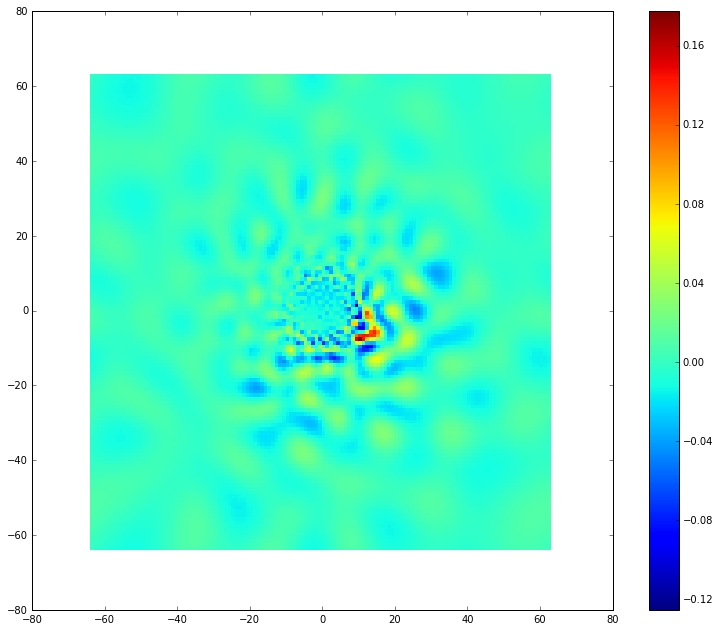

In [131]:
evaluation()